In [1]:
#import required libraries
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/home/ishadi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# concatanating the date and the time stamp into one column

In [2]:
import csv
with open('DAT_MT_EURUSD_M1_2016.csv') as f:
    reader = csv.reader(f)
    with open('output.csv', 'w') as g:
        writer = csv.writer(g)
        for row in reader:
            new_row = [' '.join([row[0], row[1]])] + row[2:]
            writer.writerow(new_row)

In [4]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y.%m.%d %H:%M')
dataset = read_csv('output.csv', date_parser=parse)
#dataset = read_csv('output.csv')
#dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['Date time stamp', 'Bar OPEN Bid Quote', 'Bar HIGH Bid Quote', 'Bar LOW Bid Quote', 'Bar CLOSE Bid Quote', 'Volume']
dataset.index.name = 'Date time stamp'

# mark all NA values with 0
dataset['Bar OPEN Bid Quote'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))
print(dataset.tail(5))

# save to file
dataset.to_csv('2016.csv')

                  Date time stamp  Bar OPEN Bid Quote  Bar HIGH Bid Quote  \
Date time stamp                                                             
0                2016.01.03 17:01             1.08712             1.08712   
1                2016.01.03 17:02             1.08708             1.08722   
2                2016.01.03 17:03             1.08717             1.08723   
3                2016.01.03 17:04             1.08718             1.08718   
4                2016.01.03 17:05             1.08703             1.08716   

                 Bar LOW Bid Quote  Bar CLOSE Bid Quote  Volume  
Date time stamp                                                  
0                          1.08712              1.08712       0  
1                          1.08708              1.08722       0  
2                          1.08717              1.08723       0  
3                          1.08711              1.08711       0  
4                          1.08701              1.08712       0 

In [9]:
#Loads the new “2016.csv” file and plots each series as a separate subplot

In [ ]:
# # load dataset
# dataset = read_csv('2016.csv', header=0, index_col=0)
# values = dataset.values

# # specify columns to plot
# groups = [0, 1, 2, 3, 4, 5]
# i = 1

# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('2016.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.000000   0.411048   0.409498   0.413382   0.411154        0.0  0.000003
2   0.000003   0.410730   0.410291   0.413062   0.411945        0.0  0.000005
3   0.000005   0.411444   0.410370   0.413779   0.412024        0.0  0.000008
4   0.000008   0.411523   0.409974   0.413301   0.411075        0.0  0.000011
5   0.000011   0.410335   0.409815   0.412505   0.411154        0.0  0.000013


In [ ]:
#LSTM with 50 neurons in the first hidden layer 
#1 neuron in the output layer for predicting foreign currency rate
#The input shape will be 1 time step with 6 features.

In [7]:
# split into train and test sets# 
values = reframed.values
#n_train_minutes = 365 * 24 * 60
n_train_minutes = 255 * 24 * 60
train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(367200, 1, 6) (367200,) (5477, 1, 6) (5477,)


In [ ]:
#The model will be fit for 50 training epochs with a batch size of 72

Train on 367200 samples, validate on 5477 samples
Epoch 1/50
 - 7s - loss: 0.0070 - val_loss: 0.0212
Epoch 2/50
 - 7s - loss: 0.0094 - val_loss: 0.0061
Epoch 3/50
 - 7s - loss: 0.0043 - val_loss: 0.0011
Epoch 4/50
 - 7s - loss: 0.0031 - val_loss: 0.0040
Epoch 5/50
 - 6s - loss: 0.0027 - val_loss: 0.0026
Epoch 6/50
 - 7s - loss: 0.0026 - val_loss: 0.0050
Epoch 7/50
 - 6s - loss: 0.0023 - val_loss: 0.0040
Epoch 8/50
 - 7s - loss: 0.0022 - val_loss: 0.0042
Epoch 9/50
 - 6s - loss: 0.0022 - val_loss: 0.0062
Epoch 10/50
 - 6s - loss: 0.0023 - val_loss: 0.0055
Epoch 11/50
 - 7s - loss: 0.0022 - val_loss: 0.0070
Epoch 12/50
 - 6s - loss: 0.0021 - val_loss: 0.0040
Epoch 13/50
 - 7s - loss: 0.0022 - val_loss: 0.0043
Epoch 14/50
 - 7s - loss: 0.0021 - val_loss: 0.0045
Epoch 15/50
 - 6s - loss: 0.0020 - val_loss: 0.0050
Epoch 16/50
 - 7s - loss: 0.0021 - val_loss: 0.0052
Epoch 17/50
 - 7s - loss: 0.0021 - val_loss: 0.0045
Epoch 18/50
 - 7s - loss: 0.0021 - val_loss: 0.0050
Epoch 19/50
 - 7s - los

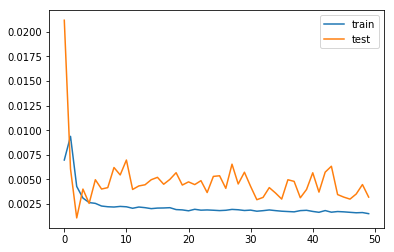

In [8]:
# design network# 
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1624.372
